In [1]:
import os
import pickle
import copy

import torch
import torch_geometric
import numpy as np
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glycowork.glycan_data.loader import lib

from glycontact.lwca import LinearWarmupCosineAnnealingLR
from glycontact.visualize import extract_torsion_angles
from glycontact.learning import GINSweetNet, VonMisesSweetNet, create_dataset, train_model, clean_split, build_baselines, evaluate_model, angular_rmse, value_rmse

# Seed everything for reproducibility
torch_geometric.seed_everything(42)

/home/rjo21/miniconda3/envs/glycontact/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sh: cd-hit: command not found
sh: cd-hit-est: command not found
sh: diamond: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mash: command not found
sh: foldseek: command not found
sh: TMalign: command not found


## Data Preprocessing

In [2]:
if not os.path.exists("conformer_split.pkl"):
    multi_train, multi_test = create_dataset()
    with open("conformer_split.pkl", "wb") as f:
        pickle.dump((multi_train, multi_test), f)
else:
    with open("conformer_split.pkl", "rb") as f:
        multi_train, multi_test = pickle.load(f)

# clean_test = clean_split(test, mode="mean")
train = clean_split(multi_train, mode="max")
test = clean_split(multi_test, mode="max")

Error for GlcNS(a1-4)IdoA(a1-4)GlcNS(a1-4)GlcA(b1-4)GlcNAc6S(a1-4)GlcA(b1-4)GlcNS6S(a1-4)IdoA2S(a1-4)GlcNAc(a1-4)GlcA: 'UYS6SO36SO3'
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
Gal(a1-3)Gal(b1-3)GalNAc, Conformer cluster0_alpha is None
The graphs are not isomorphic with the given attribute constraints.
Error for Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc: 2
Error for IdoA2S(a1-4)GlcNS6S(a1-4)IdoA2S(a1-4)GlcNS6S(a1-4)IdoA2S(a1-4)GlcNS6S: 'IDR2SO32SO3'
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with 

/home/rjo21/miniconda3/envs/glycontact/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:208: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[GlcNAc(b1-2)Man(a1-6)][GlcNAc(b1-4)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc, Conformer cluster0_alpha is None
The graphs are not isomorphic with the given attribute constraints.
The graphs are not isomorphic with the given attribute constraints.
Neu5Ac(a2-3)Gal(b1-4)Glc

In [4]:
len(train), len(test), len(multi_train), len(multi_test)

(357, 117, 3605, 1155)

## Model Training

#### Single Conformer

In [5]:
# Monomer baselines
mean_phi_predictor, mean_psi_predictor, mean_sasa_predictor, mean_flex_predictor = build_baselines([d[1] for d in train], np.mean)
median_phi_predictor, median_psi_predictor, median_sasa_predictor, median_flex_predictor = build_baselines([d[1] for d in train], np.median)

In [6]:
model = GINSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
optim = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optim, mode="min", factor=0.1, patience=10, threshold=1e-4, cooldown=5, min_lr=1e-6)
metrics, model = train_model(
    model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in test], batch_size=64),
    },
    optim,
    scheduler,
    num_epochs=150,
)

Epoch 0/149
----------
train Loss: 10.2915 Phi: 1.5057 Psi: 2.9478 SASA: 222.9923 Flex: 2.1215 LR: 0.0100
val Loss: 41.6899 Phi: 1.3292 Psi: 2.3980 SASA: 174.8324 Flex: 35.0489 LR: 0.0100

Epoch 1/149
----------
train Loss: 9.6548 Phi: 1.4862 Psi: 2.9355 SASA: 221.7856 Flex: 1.5367 LR: 0.0100
val Loss: 21.5689 Phi: 1.3204 Psi: 2.5051 SASA: 180.8011 Flex: 14.7300 LR: 0.0100

Epoch 2/149
----------
train Loss: 9.6122 Phi: 1.4676 Psi: 2.9225 SASA: 220.5399 Flex: 1.5465 LR: 0.0100
val Loss: 9.9517 Phi: 1.3701 Psi: 2.6066 SASA: 200.8057 Flex: 2.6283 LR: 0.0100

Epoch 3/149
----------
train Loss: 9.4681 Phi: 1.4381 Psi: 2.9053 SASA: 219.0129 Flex: 1.4745 LR: 0.0100
val Loss: 9.7060 Phi: 1.3787 Psi: 2.6879 SASA: 208.4140 Flex: 2.1658 LR: 0.0100

Epoch 4/149
----------
train Loss: 9.3276 Phi: 1.4081 Psi: 2.8800 SASA: 217.6876 Flex: 1.4114 LR: 0.0100
val Loss: 9.4401 Phi: 1.3308 Psi: 2.7141 SASA: 208.9981 Flex: 1.9118 LR: 0.0100

Epoch 5/149
----------
train Loss: 9.1714 Phi: 1.3723 Psi: 2.8493

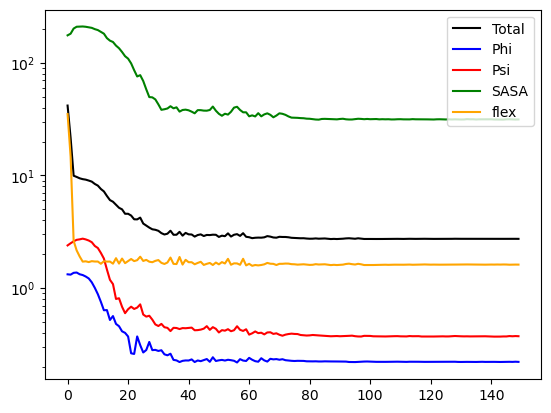

In [7]:
plt.plot(metrics["val"]["loss"], c="black", label="Total")
plt.plot(metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()

plt.show()

In [8]:
print("Mean:\n\t", evaluate_model((mean_phi_predictor, mean_psi_predictor, mean_sasa_predictor, mean_flex_predictor), multi_test)[:4])
print("Median:\n\t", evaluate_model((median_phi_predictor, median_psi_predictor, median_sasa_predictor, median_flex_predictor), multi_test)[:4])
m_psi, m_phi, m_sasa, m_flex, m_pred = evaluate_model(model, multi_test)
print("GINSweetNet:\n\t", m_psi, m_phi, m_sasa, m_flex)

Mean:
	 (35.011999549990506, 66.15607911615676, 47.108035194177006, 1.8327257110986233)
Median:
	 (34.413874301865924, 49.74527512126281, 48.113236250128686, 1.9526027275666464)
1155 / 1155
GINSweetNet:
	 27.60594610620301 36.98068639301087 31.85808944332304 1.6447993013853952


#### Multi-Conformer

In [9]:
# Monomer baselines
multi_mean_phi_predictor, multi_mean_psi_predictor, multi_mean_sasa_predictor, multi_mean_flex_predictor = build_baselines([d[1] for d in multi_train], np.mean)
multi_median_phi_predictor, multi_median_psi_predictor, multi_median_sasa_predictor, multi_median_flex_predictor = build_baselines([d[1] for d in multi_train], np.median)

In [10]:
multi_model = VonMisesSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
multi_optim = torch.optim.Adam(multi_model.parameters(), lr=0.001)
multi_scheduler = LinearWarmupCosineAnnealingLR(optimizer=multi_optim, warmup_epochs=25, max_epochs=50, warmup_start_lr=1e-5, eta_min=1e-7)
multi_metrics, multi_model = train_model(
    multi_model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in multi_train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in multi_test], batch_size=64),
    },
    multi_optim,
    multi_scheduler,
    num_epochs=150,
)

Epoch 0/149
----------
train Loss: 9.6445 Phi: 1.6533 Psi: 1.7995 SASA: 223.4301 Flex: 2.4678 LR: 0.0000
val Loss: 9.6104 Phi: 1.4812 Psi: 1.7799 SASA: 222.9020 Flex: 2.6343 LR: 0.0000

Epoch 1/149
----------
train Loss: 9.1970 Phi: 1.5369 Psi: 1.6114 SASA: 223.3517 Flex: 2.3262 LR: 0.0001
val Loss: 8.7791 Phi: 1.3201 Psi: 1.4066 SASA: 222.8450 Flex: 2.3384 LR: 0.0001

Epoch 2/149
----------
train Loss: 8.5819 Phi: 1.3803 Psi: 1.4289 SASA: 223.2107 Flex: 2.0525 LR: 0.0001
val Loss: 8.2149 Phi: 1.1755 Psi: 1.2907 SASA: 222.6921 Flex: 2.0372 LR: 0.0001

Epoch 3/149
----------
train Loss: 7.8292 Phi: 1.1330 Psi: 1.3053 SASA: 223.0333 Flex: 1.6736 LR: 0.0001
val Loss: 7.3770 Phi: 0.8871 Psi: 1.1624 SASA: 222.3764 Flex: 1.6212 LR: 0.0001

Epoch 4/149
----------
train Loss: 7.0878 Phi: 0.7947 Psi: 1.1522 SASA: 222.7179 Flex: 1.4289 LR: 0.0002
val Loss: 7.0021 Phi: 0.6757 Psi: 1.0055 SASA: 222.1029 Flex: 1.6192 LR: 0.0002

Epoch 5/149
----------
train Loss: 6.6339 Phi: 0.5790 Psi: 1.0221 SASA

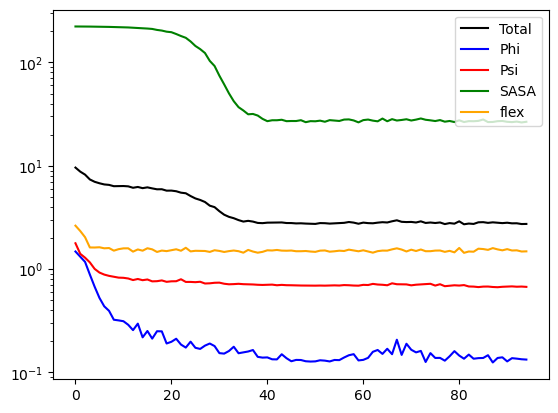

In [11]:
plt.plot(multi_metrics["val"]["loss"], c="black", label="Total")
plt.plot(multi_metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(multi_metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(multi_metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(multi_metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()

plt.show()

In [12]:
print("Mean:\n\t", evaluate_model((multi_mean_phi_predictor, multi_mean_psi_predictor, multi_mean_sasa_predictor, multi_mean_flex_predictor), multi_test)[:4])
print("Median:\n\t", evaluate_model((multi_median_phi_predictor, multi_median_psi_predictor, multi_median_sasa_predictor, multi_median_flex_predictor), multi_test)[:4])
mm_psi, mm_phi, mm_sasa, mm_flex, mm_pred = evaluate_model(multi_model, multi_test)
print("VonMisesSweetNet:\n\t", mm_psi, mm_phi, mm_sasa, mm_flex)
print("(Phi RMSE, PSI RMSE, SASA RMSE, Flexibility RMSE)")

Mean:
	 (34.626746345870835, 65.34497723998167, 47.34057648343075, 1.8412763890877752)
Median:
	 (34.860859324263444, 49.41099861287947, 48.50275314182418, 1.942614739614679)
1155 / 1155
VonMisesSweetNet:
	 31.464389977782204 44.95470343766356 27.32031082312917 1.6137002674036471
(Phi RMSE, PSI RMSE, SASA RMSE, Flexibility RMSE)


## Visulaze Multi-Conformer VonMisesSweetNet

In [13]:
def ramachandran_plot(
        disaccharide: str, 
        structure_graphs: list[nx.DiGraph],
        density: bool = True,
        ax: plt.Axes = None,
        mode: str = None,
        split: str = None,
        conf: str = None,
) -> plt.Figure:
    """Generate a Ramachandran plot for a specific disaccharide linkage.
    Args:
    disaccharide: String representing the disaccharide (e.g., "Fuc(a1-2)Gal")
    structure_graphs: Dictionary of glycan structure graphs
    density: Whether to show density contours (default: True)
    filepath: Path to save the figure (optional)
    Returns:
    Matplotlib figure object
    """
    phi_angles, psi_angles = extract_torsion_angles(disaccharide, dict(enumerate(structure_graphs)))
    if not phi_angles or not psi_angles:
        raise ValueError(f"No torsion angles found for disaccharide: {disaccharide}")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create density contours if requested
    if density and len(phi_angles) > 3:
        # Calculate the point density
        xy = np.vstack([phi_angles, psi_angles])
        z = stats.gaussian_kde(xy)(xy)
        # Sort the points by density for better visualization
        idx = z.argsort()
        x_sorted, y_sorted, z_sorted = np.array(phi_angles)[idx], np.array(psi_angles)[idx], z[idx]
        # Clear the previous plot and redraw with density coloring
        ax.clear()
        scatter = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=30, cmap='viridis')
        plt.colorbar(scatter, ax=ax, label='Density')
    else:
        # Create the scatter plot
        ax.scatter(phi_angles, psi_angles, alpha=0.7, s=30, c='blue', edgecolor='white')

    # Set plot limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi (°)')
    ax.set_ylabel('Psi (°)')
    ax.set_title(f'Ramachandran Plot for {(mode + " ") if mode else ""}{disaccharide} angles{(" in " + split) if split else ""} {conf} conformers')
    # Add grid lines
    ax.grid(alpha=0.3)
    # Add the origin lines
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    # Add statistics
    stats_text = (
        f"n = {len(phi_angles)}\n"
        f"Mean φ = {np.mean(phi_angles):.1f}° ± {np.std(phi_angles):.1f}°\n"
        f"Mean ψ = {np.mean(psi_angles):.1f}° ± {np.std(psi_angles):.1f}°"
    )
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

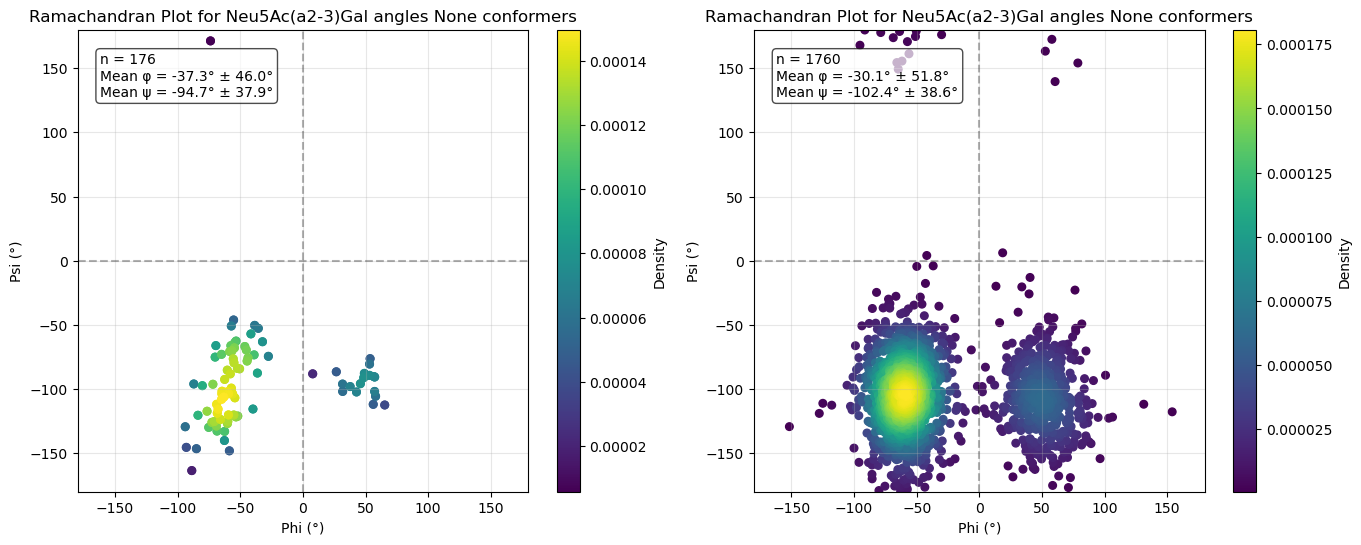

In [14]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=mm_pred, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

The same plot with the GINSweetNet, highlighting the difference in generative power.

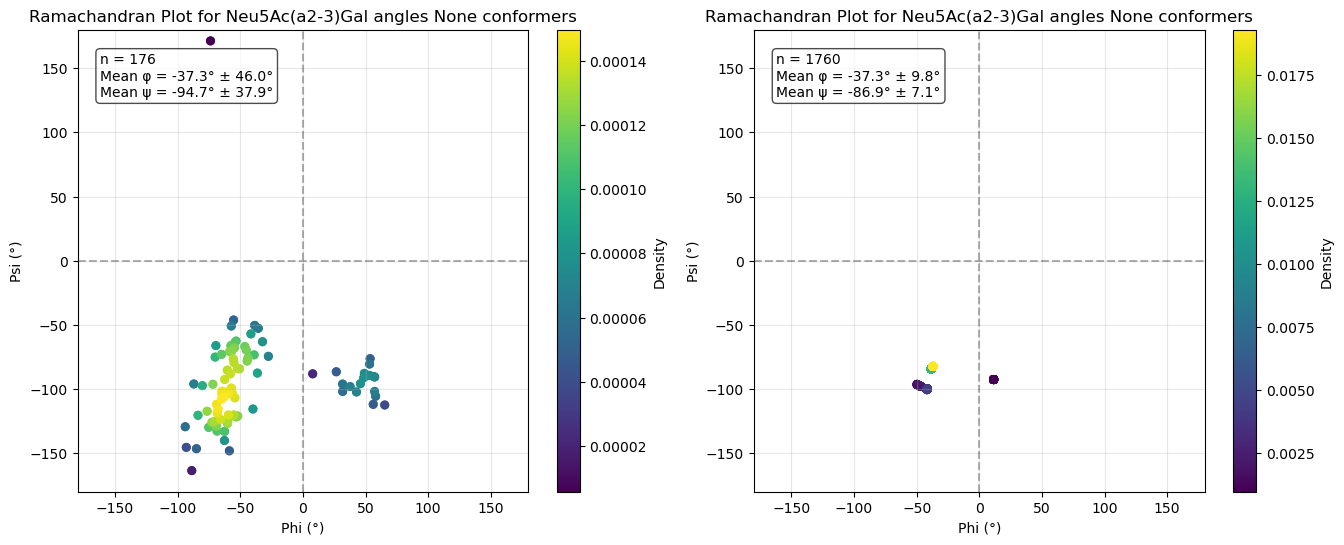

In [15]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=m_pred, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

A OOD plot with the VonMisesSweetNet. Rha(a1-3)GalNAc is not contained in the training data.

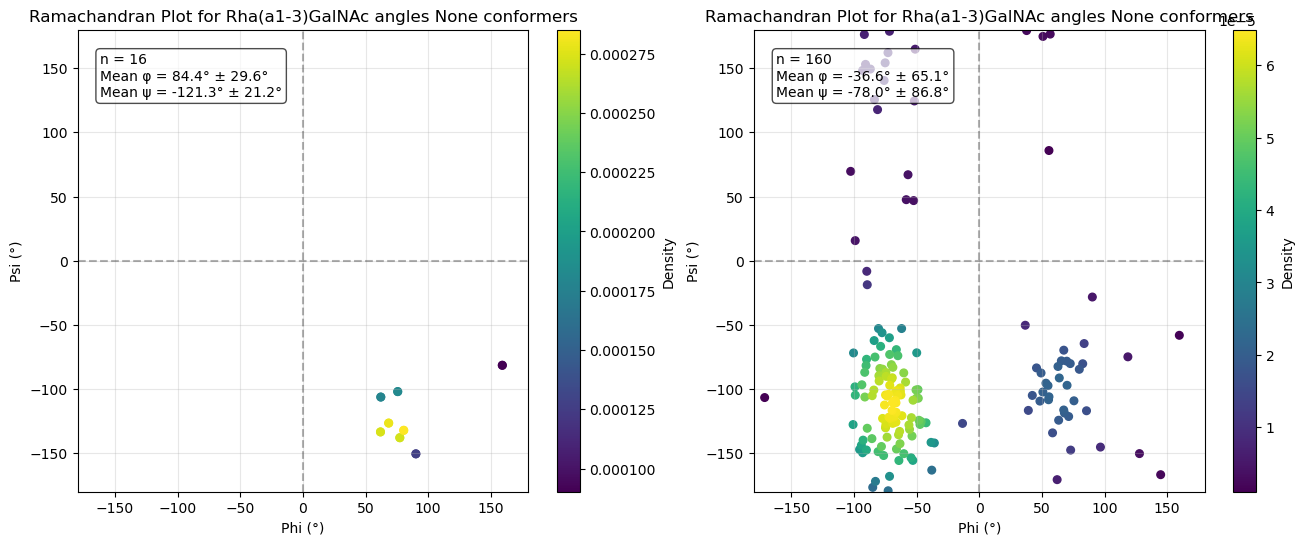

In [16]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Rha(a1-3)GalNAc", structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Rha(a1-3)GalNAc", structure_graphs=mm_pred, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

0.9157538507357408


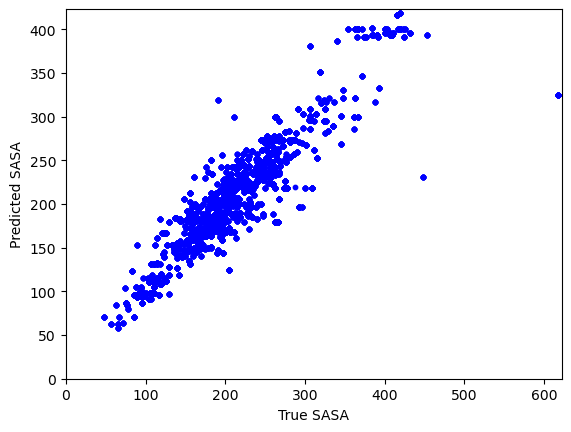

In [17]:
def plot_value_distributions(
        true_graphs: list[nx.DiGraph],
        pred_graphs: list[nx.DiGraph],
        value_name: str,
):
    true_values, pred_values = [], []
    for true_graph, pred_graph in zip(true_graphs, pred_graphs):
        for n in true_graph.nodes:
            if value_name in true_graph.nodes[n] and value_name in pred_graph.nodes[n]:
                true_values.append(true_graph.nodes[n][value_name])
                pred_values.append(pred_graph.nodes[n][value_name])
    
    plt.scatter(true_values, pred_values, s=10, marker="o", c="blue")
    print(np.corrcoef(true_values, pred_values)[0, 1])
    plt.xlim(0, min(5 + max(true_values), 1.2 * max(true_values)))
    plt.ylim(0, min(5 + max(pred_values), 1.2 * max(pred_values)))
    plt.xlabel(f"True {value_name}")
    plt.ylabel(f"Predicted {value_name}")

plot_value_distributions(
    [t[1] for t in multi_test], 
    [mm_pred[x] for x in range(0, len(mm_pred), 10)],
    value_name="SASA",
)

0.5194283958619058


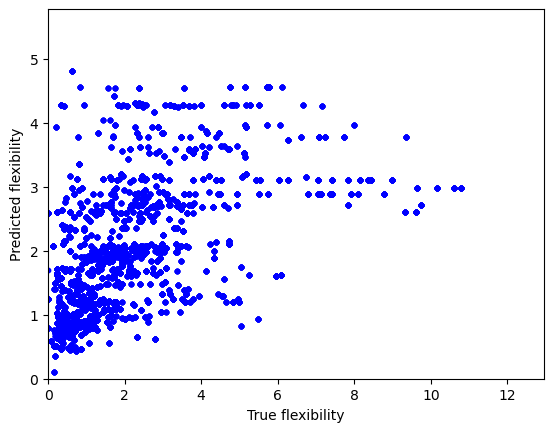

In [18]:
plot_value_distributions(
    [t[1] for t in multi_test], 
    [mm_pred[x] for x in range(0, len(mm_pred), 10)],
    value_name="flexibility",
)

## Ablation studies (unfinished!)

In [19]:
data = dict()
for t, _ in multi_test:
    if t.iupac not in data:
        data[t.iupac] = [0, t.iupac.count("(")]
    data[t.iupac][0] += 1
data = list(sorted(data.items(), key=lambda x: x[1][0] / (x[1][1] + 1e-5), reverse=True))
data[:20]

[('Fuc', [1, 0]),
 ('Glc(a1-4)Rha', [18, 1]),
 ('Man(b1-4)Gal(a1-4)Rha', [16, 2]),
 ('GlcNAc(b1-6)GlcNAc(b1-6)GlcNAc', [16, 2]),
 ('Glc(b1-4)GlcA(a1-3)Fuc', [16, 2]),
 ('Rha(a1-3)GalNAc(a1-3)GalNAc', [16, 2]),
 ('GlcNAc(b1-3)Fuc', [8, 1]),
 ('Araf(b1-2)Araf', [8, 1]),
 ('IdoA2S(a1-4)GlcNS6S', [8, 1]),
 ('GlcNAc(b1-4)GlcNAc', [8, 1]),
 ('Gal(b1-4)Glc', [8, 1]),
 ('Gal(b1-4)GlcNAc(b1-2)Man', [14, 2]),
 ('Neu5Ac(a2-6)GalNAc(a1-3)GlcNAc', [14, 2]),
 ('Rha(a1-2)Rha(a1-2)Rha', [14, 2]),
 ('Rha(a1-2)Rha(a1-3)Rha(a1-3)GlcNAc', [20, 3]),
 ('Man(a1-3)Man(a1-3)GlcNAc', [12, 2]),
 ('Gal(a1-3)Gal(a1-3)Gal', [12, 2]),
 ('Gal(b1-3)GalNAc(a1-3)GlcNAc', [12, 2]),
 ('GalNAc(b1-3)Gal(a1-3)Gal(b1-4)Glc', [16, 3]),
 ('Gal(b1-3)[Neu5Gc(a2-6)]GalNAc', [10, 2])]

In [20]:
test_spec = [i for i, t in enumerate(multi_test) if t[0].iupac == "Man(a1-3)Man(a1-3)GlcNAc"]
test_spec = test_spec[:6]
print(test_spec)
for i in test_spec:
    print(multi_test[i][0].conformer)

[170, 171, 172, 173, 174, 175]
cluster0_alpha
cluster1_alpha
cluster2_alpha
cluster3_alpha
cluster4_alpha
cluster5_alpha


In [21]:
conformer_torsion_angles = []
bond1 = extract_torsion_angles("Man(a1-3)Man", {str(i): multi_test[conformer_idx][1] for i, conformer_idx in enumerate(test_spec)})
bond2 = extract_torsion_angles("Man(a1-3)GlcNAc", {str(i): multi_test[conformer_idx][1] for i, conformer_idx in enumerate(test_spec)})
for conformer_idx in test_spec[:8]:
    b1 = extract_torsion_angles("Man(a1-3)Man", {str(i): p for i, p in enumerate(mm_pred[conformer_idx * 10 : (conformer_idx + 1) * 10])})
    b2 = extract_torsion_angles("Man(a1-3)GlcNAc", {str(i): p for i, p in enumerate(mm_pred[conformer_idx * 10 : (conformer_idx + 1) * 10])})
    conformer_torsion_angles.append((b1, b2))

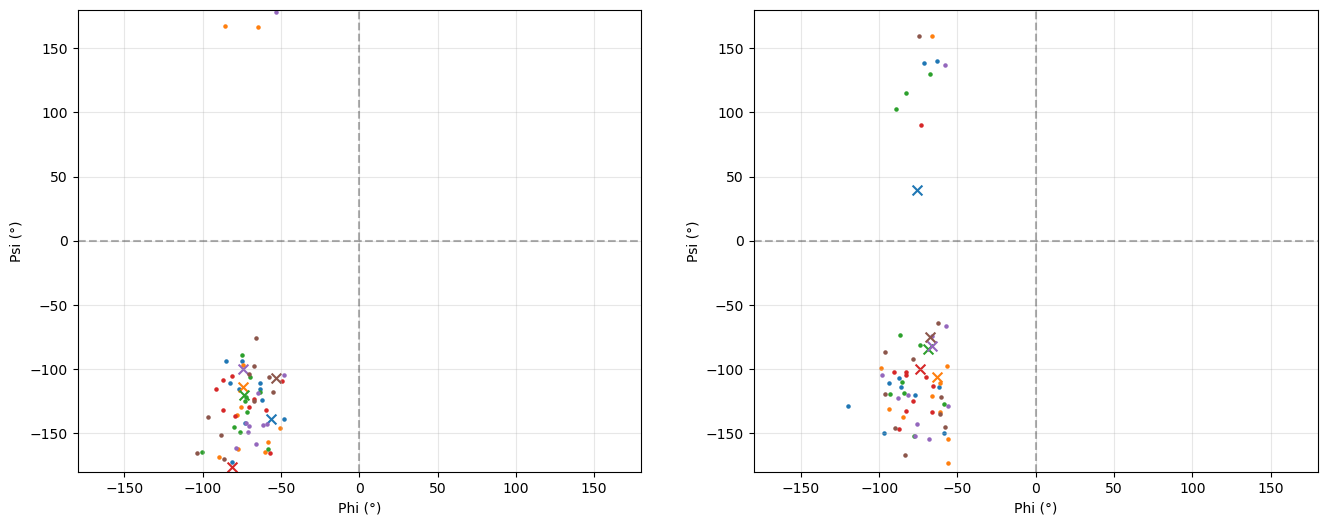

In [22]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
for cid in range(len(test_spec)):
    axs[0].scatter(bond1[0][cid], bond1[1][cid], alpha=1, s=50, marker="x", color=f"C{cid}")
    axs[0].scatter(conformer_torsion_angles[cid][0][0], conformer_torsion_angles[cid][0][1], alpha=1, s=20, marker=".", color=f"C{cid}")
for cid in range(len(test_spec)):
    axs[1].scatter(bond2[0][cid], bond2[1][cid], alpha=1, s=50, marker="x", color=f"C{cid}")
    axs[1].scatter(conformer_torsion_angles[cid][1][0], conformer_torsion_angles[cid][1][1], alpha=1, s=20, marker=".", color=f"C{cid}")

for i in range(2):
    axs[i].set_xlim(-180, 180)
    axs[i].set_ylim(-180, 180)
    axs[i].set_xlabel('Phi (°)')
    axs[i].set_ylabel('Psi (°)')
    # ax.set_title(f'Ramachandran Plot for {(mode + " ") if mode else ""}{disaccharide} angles{(" in " + split) if split else ""} {conf} conformers')
    # Add grid lines
    axs[i].grid(alpha=0.3)
    # Add the origin lines
    axs[i].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axs[i].axvline(x=0, color='k', linestyle='--', alpha=0.3)